In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute

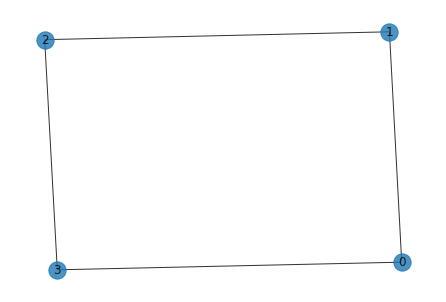

In [2]:
edges = [(0,1), (1,2), (2,3), (3,0)]
G = nx.Graph(edges)
nx.draw(G, with_labels=True, alpha=0.8)

In [3]:
def maxcut_obj(x, G):
    # x is the input bit string
    # Output will be the maxcut function value using x bit string
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
    return obj

In [4]:
def create_qaoa_circ(G, theta):
    nqubits = len(G.nodes()) 
    qc = QuantumCircuit(nqubits)
    clauses = len(G.edges())
    nlayers = len(theta)//(nqubits+clauses)
    beta = np.reshape(theta[:nlayers*nqubits], (nlayers,nqubits))
    gamma = np.reshape(theta[nlayers*nqubits:], (nlayers,clauses))
    
    for i in range(nqubits):
        qc.h(i)
    
    for irep in range(nlayers):
        k=0
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep,k], pair[0], pair[1])
            qc.barrier()
            k+=1
        # mixer unitary
        for i in range(nqubits):
            qc.rx(2 * beta[irep,i], i)
        
    qc.measure_all()
    return qc

In [5]:
def compute_expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [6]:
def get_expectation(G, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        return compute_expectation(counts, G)
    
    return execute_circ

[1 1 2 3 1 1 2 3 1 2 3 3 1 2 3 3]


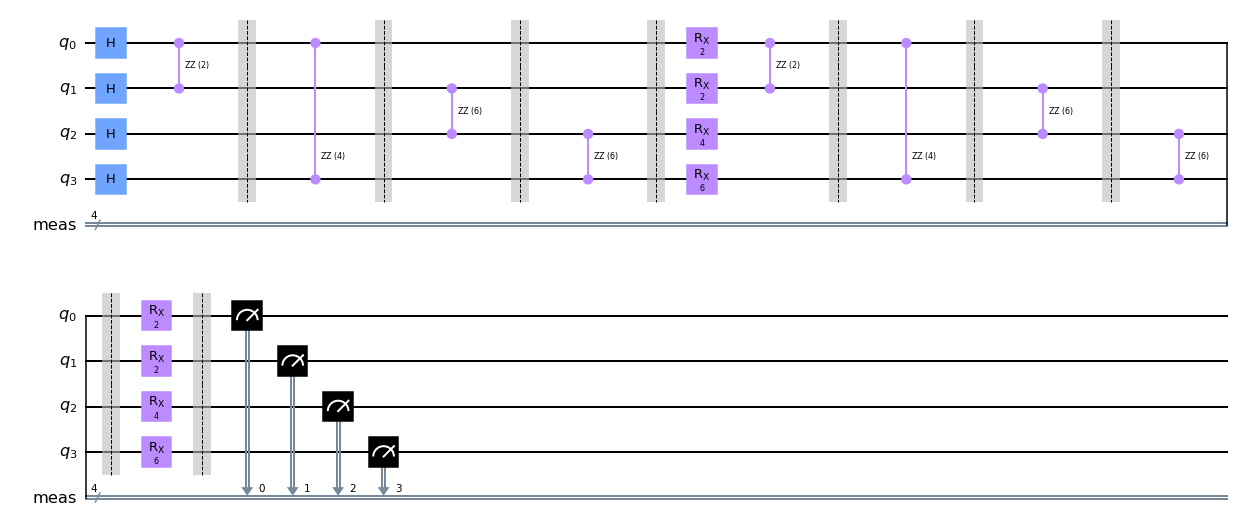

In [10]:
# Adding Parameters
beta = np.array([[1,1,2,3],[1,1,2,3]]) #Edit as per the number of qubits
gamma = np.array([[1,2,3,3],[1,2,3,3]]) #Edit as per the number of clauses
theta = np.concatenate((beta.flatten(), gamma.flatten()))
print(theta)
qc = create_qaoa_circ(G, theta)
qc.draw()

In [11]:
from scipy.optimize import minimize
expectation = get_expectation(G)
res = minimize(expectation, theta, method='COBYLA')
res

     fun: -3.990234375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 180
  status: 1
 success: True
       x: array([0.77415976, 1.93971574, 2.46982545, 3.1889727 , 2.33291699,
       2.3853679 , 1.9733159 , 3.13346888, 0.81268849, 2.32314952,
       3.11512219, 2.7258298 , 0.85280977, 1.96377018, 3.13703012,
       4.02450811])

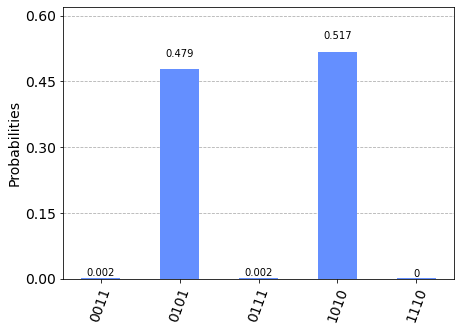

In [12]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)